# **mPING MLP Modeling**

Baseline modeling for mPING data.

In [1]:
import yaml, glob
import pandas as pd
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import cm
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
import utils

## Data Loading

In [2]:
# Load config file
config = "config.yml"
with open(config) as f:
    conf = yaml.load(f, Loader=yaml.FullLoader)

In [3]:
# Define input and output features
input_cols = conf["tempvars"] + conf["tempdewvars"] + conf["ugrdvars"] + conf["vgrdvars"]
output_cols = conf["outputvars"]

In [4]:
arr = sorted(glob.glob(conf['mping_path']+'*'))

In [5]:
df = pd.concat([pd.read_parquet(x) for x in tqdm.tqdm(arr)])

100%|██████████| 2499/2499 [02:53<00:00, 14.38it/s]


In [6]:
df = df[df["datetime"] < "2018-01-01 00:00:00"]

## Preprocessing

In [47]:
df['day'] = df['datetime'].apply(lambda x: str(x).split(' ')[0])

In [48]:
splitter = GroupShuffleSplit(n_splits=1, train_size=0.9)

In [49]:
train_idx, test_idx = list(splitter.split(df, groups=df['day']))[0]
train_data, test_data = df.iloc[train_idx], df.iloc[test_idx]

In [50]:
splitter = GroupShuffleSplit(n_splits=1, train_size=0.885, random_state=123)
train_idx, valid_idx = list(splitter.split(train_data, groups=train_data['day']))[0]
train_data, valid_data = train_data.iloc[train_idx], train_data.iloc[valid_idx]

In [51]:
train_data.shape, valid_data.shape, test_data.shape

((482362, 408), (65037, 408), (61241, 408))

In [52]:
scaler_x = StandardScaler()

In [53]:
x_train = scaler_x.fit_transform(train_data[input_cols])

In [54]:
x_valid = scaler_x.transform(valid_data[input_cols])

In [55]:
x_test = scaler_x.transform(test_data[input_cols])

In [56]:
def one_hot(x):
    a = np.zeros(len(output_cols))
    a[x] = 1
    return a

In [57]:
test_data.tail()

,datetime,lat,lon,report_count,ra_percent,sn_percent,pl_percent,fzra_percent,CFRZR_-,CICEP_-,...,VVEL_800_Pa/s,VVEL_825_Pa/s,VVEL_850_Pa/s,VVEL_875_Pa/s,VVEL_900_Pa/s,VVEL_925_Pa/s,VVEL_950_Pa/s,VVEL_975_Pa/s,idx,day
740,2017-12-30 23:00:00,42.843583,286.216966,1,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.184371,-0.161804,-0.12937,-0.115165,-0.105861,-0.054912,-0.040041,0.045313,"[203, 380]",2017-12-30
741,2017-12-30 23:00:00,42.865778,281.443492,1,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.246871,-0.255554,-0.31687,-0.396415,-0.449611,-0.492412,-0.477541,-0.267187,"[199, 350]",2017-12-30
742,2017-12-30 23:00:00,43.123236,282.442788,1,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.434371,-0.474304,-0.56687,-0.615165,-0.668361,-0.648662,-0.477541,-0.235937,"[202, 356]",2017-12-30
743,2017-12-30 23:00:00,43.137979,282.285929,1,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.278121,-0.318054,-0.34812,-0.427665,-0.480861,-0.461162,-0.352541,-0.173437,"[202, 355]",2017-12-30
744,2017-12-30 23:00:00,43.222783,282.620093,1,0.0,1.0,0.0,0.0,0.0,0.0,...,-1.309371,-1.505554,-1.66062,-1.708915,-1.668361,-1.461162,-1.071291,-0.548437,"[203, 357]",2017-12-30


In [58]:
train_data['label'] = train_data[output_cols].idxmax(axis=1).apply(lambda x: one_hot(output_cols.index(x)))
y_train = train_data['label'].to_numpy()
y_train = np.vstack(y_train)

In [59]:
valid_data['label'] = valid_data[output_cols].idxmax(axis=1).apply(lambda x: one_hot(output_cols.index(x)))
y_valid = valid_data['label'].to_numpy()
y_valid = np.vstack(y_valid)

In [60]:
test_data['label'] = test_data[output_cols].idxmax(axis=1).apply(lambda x: one_hot(output_cols.index(x)))
y_test = test_data['label'].to_numpy()
y_test = np.vstack(y_test)

/glade/work/eliotk/conda-envs/pyenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Model Training

In [103]:
# Set batch size
batch_size = conf["batch_size"]

In [104]:
def build_model(input_size, hidden_size, output_size):
    model = tf.keras.models.Sequential(
        [tf.keras.layers.Dense(input_size, activation='relu'),
        tf.keras.layers.Dense(hidden_size, activation='relu'),
        tf.keras.layers.Dense(output_size, activation='softmax')]
    )
    return model

In [105]:
model = build_model(len(input_cols), 100, len(output_cols))
model.build((batch_size, len(input_cols)))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (4096, 268)               72092     
                                                                 
 dense_7 (Dense)             (4096, 100)               26900     
                                                                 
 dense_8 (Dense)             (4096, 4)                 404       
                                                                 
Total params: 99,396
Trainable params: 99,396
Non-trainable params: 0
_________________________________________________________________


In [106]:
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(loss=loss, optimizer=optimizer, metrics='acc', run_eagerly=True) 

In [107]:
history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=batch_size, shuffle=True, epochs=25) 

Epoch 1/25
16/16 [==============================] - 1s 66ms/step - loss: 0.7459 - acc: 0.7312 - val_loss: 0.4824 - val_acc: 0.8374
Epoch 2/25
16/16 [==============================] - 1s 58ms/step - loss: 0.4428 - acc: 0.8479 - val_loss: 0.4101 - val_acc: 0.8542
Epoch 3/25
16/16 [==============================] - 1s 57ms/step - loss: 0.3951 - acc: 0.8579 - val_loss: 0.3807 - val_acc: 0.8638
Epoch 4/25
16/16 [==============================] - 1s 54ms/step - loss: 0.3738 - acc: 0.8659 - val_loss: 0.3653 - val_acc: 0.8692
Epoch 5/25
16/16 [==============================] - 1s 56ms/step - loss: 0.3605 - acc: 0.8702 - val_loss: 0.3540 - val_acc: 0.8732
Epoch 6/25
16/16 [==============================] - 1s 53ms/step - loss: 0.3515 - acc: 0.8739 - val_loss: 0.3457 - val_acc: 0.8758
Epoch 7/25
16/16 [==============================] - 1s 56ms/step - loss: 0.3437 - acc: 0.8771 - val_loss: 0.3384 - val_acc: 0.8795
Epoch 8/25
16/16 [==============================] - 1s 55ms/step - loss: 0.3364 - a

## Model Evaluation

In [108]:
y_pred_onehot = model.predict(x_test)

In [109]:
y_pred_train_onehot = model.predict(x_train)

In [110]:
# Converting one-hot labels to categorical labels
y_pred_labels = np.argmax(y_pred_onehot, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

In [111]:
y_pred_train_labels = np.argmax(y_pred_train_onehot, axis=1)
y_train_labels = np.argmax(y_train, axis=1)

In [112]:
accuracy_score(y_test_labels, y_pred_labels)

0.8728956091507324

In [113]:
accuracy_score(y_train_labels, y_pred_train_labels)

0.8994572320371481

Confusion matrix, without normalization
[[37438  1057   308   112]
 [ 1290 14905   450    77]
 [ 1049  1550   825   116]
 [  851   598   326   289]]
Normalized confusion matrix
[[0.96 0.03 0.01 0.  ]
 [0.08 0.89 0.03 0.  ]
 [0.3  0.44 0.23 0.03]
 [0.41 0.29 0.16 0.14]]


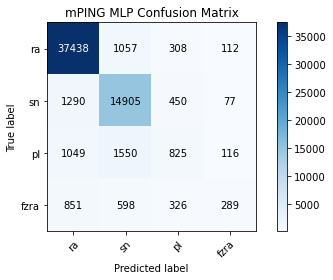

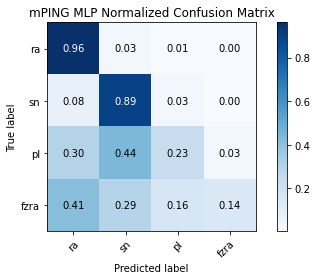

In [114]:
np.set_printoptions(precision=2)
# class_names = [str(x) for x in sorted(set(y_test_labels))]
class_names = ["ra", "sn", "pl", "fzra"]

# Plot non-normalized confusion matrix
utils.plot_confusion_matrix(y_test_labels, y_pred_labels, classes=class_names,
                      title='mPING MLP Confusion Matrix')

# Plot normalized confusion matrix
utils.plot_confusion_matrix(y_test_labels, y_pred_labels, classes=class_names, normalize=True,
                      title='mPING MLP Normalized Confusion Matrix')

plt.show()

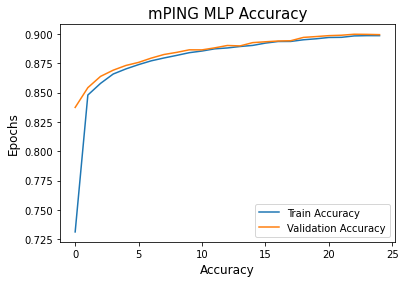

In [115]:
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.xlabel("Accuracy", fontsize=12)
plt.ylabel("Epochs", fontsize=12)
plt.title("mPING MLP Accuracy", fontsize=15) 
plt.legend(["Train Accuracy", "Validation Accuracy"])

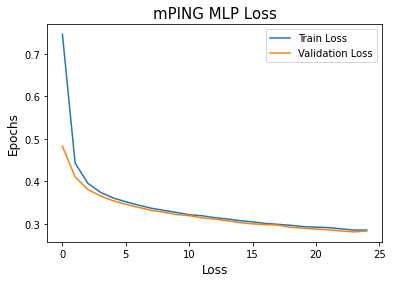

In [116]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Loss", fontsize=12)
plt.ylabel("Epochs", fontsize=12)
plt.title("mPING MLP Loss", fontsize=15) 
plt.legend(["Train Loss", "Validation Loss"])

In [117]:
model.save("/glade/work/eliotk/modeling/mping_rand2_mlp")

INFO:tensorflow:Assets written to: /glade/work/eliotk/modeling/mping_rand2_mlp/assets


In [118]:
np.save("/glade/work/eliotk/modeling/mping_rand2_x_train", x_train)

In [119]:
np.save("/glade/work/eliotk/modeling/mping_rand2_y_train", y_train)

In [120]:
np.save("/glade/work/eliotk/modeling/mping_rand2_x_train", x_valid)

In [121]:
np.save("/glade/work/eliotk/modeling/mping_rand2_y_train", y_valid)

In [122]:
np.save("/glade/work/eliotk/modeling/mping_rand2_x_test", x_test)

In [123]:
np.save("/glade/work/eliotk/modeling/mping_rand2_y_test", y_test)

## **XAI: Permutation Importance**

## Backwards Singlepass Permutation Importance

### Set-Up

In [5]:
from PermutationImportance import permutation_importance
from sklearn.metrics import accuracy_score

In [37]:
x_train = np.load("/glade/work/eliotk/modeling/mping_x_train.npy")
y_train = np.load("/glade/work/eliotk/modeling/mping_y_train.npy")
x_test = np.load("/glade/work/eliotk/modeling/mping_x_test.npy")
y_test = np.load("/glade/work/eliotk/modeling/mping_y_test.npy")
model = tf.keras.models.load_model('/glade/work/eliotk/modeling/mping_initial_mlp')

In [7]:
i = 0
def score_model(training_data, scoring_data):
    """Custom function to use for scoring. Notice that we are using a global
    model here, rather than just reassemble the model each time

    :param training_data: should be ignored for permutation importance
    :param scoring_data: (scoring_inputs, scoring_outputs)
    """
    global i
    scoring_ins, scoring_outs = scoring_data
    pred = np.argmax(model.predict(scoring_ins), axis=1)
    acc = accuracy_score(np.argmax(scoring_outs, axis=1), pred)
    # print(f"iter {i}, prop pl {sum(pred == 1) / len(pred)}, acc {acc}")
    i = i + 1
    return acc

In [169]:
scoring_data = (x_train, y_train)

In [ ]:
result = permutation_importance(scoring_data, score_model, 'min', variable_names=input_cols, nimportant_vars=1)

In [171]:
singlepass = result.retrieve_singlepass()

In [172]:
temp = pd.DataFrame(singlepass).transpose()
temp.columns = ["Rank", "Accuracy"]
temp.to_csv("perm_imp_full_single_corrected.csv")

### Evaluation

In [5]:
singlepass_results = pd.read_csv("perm_imp_full_single_corrected.csv", index_col=0)

In [6]:
colors = {"TEM":"teal", "T_D":"paleturquoise", "UGR":"maroon", "VGR":"indianred"}

In [7]:
color_values = ["teal", "paleturquoise", "maroon", "indianred"]

In [8]:
bar_colors = [colors[i] for i in [var[:3] for var in singlepass_results.index]]

In [9]:
m = 10
temp_hand = mlines.Line2D([], [], color=color_values[0], marker='o', linestyle="None", label="Temp", markersize=m)
dewtemp_hand = mlines.Line2D([], [], color=color_values[1], marker='o', linestyle="None", label="Dewpoint Temp", markersize=m)
ugrd_hand = mlines.Line2D([], [], color=color_values[2], marker='o', linestyle="None", label="u-Wind", markersize=m)
vgrd_hand = mlines.Line2D([], [], color=color_values[3], marker='o', linestyle="None", label="v-Wind", markersize=m)

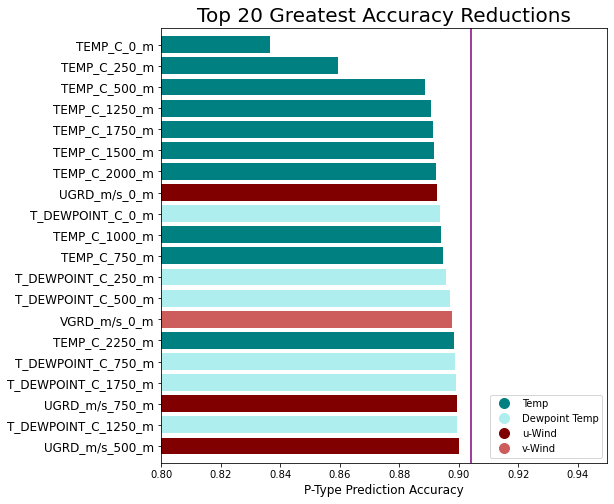

In [10]:
plt.figure(figsize=(8, 8))
plt.barh(singlepass_results.index[19::-1], singlepass_results.iloc[:, 1][19::-1], color=bar_colors[19::-1])
plt.yticks(fontsize=12)
plt.xlim(0.80, 0.95)
plt.margins(y=0.02)
plt.axvline(x=0.9042, color="purple")
plt.xlabel("P-Type Prediction Accuracy", fontsize=12)
plt.title("Top 20 Greatest Accuracy Reductions", fontsize=20)
plt.legend(handles=[temp_hand, dewtemp_hand, ugrd_hand, vgrd_hand], loc="lower right")
plt.savefig("perm_imp_full_single.png", dpi=300, bbox_inches="tight")a

In [11]:
temp_imp = np.array([singlepass_results.loc[var] for var in singlepass_results.index if "TEMP_C" in var])
dewtemp_imp = np.array([singlepass_results.loc[var] for var in singlepass_results.index if "T_DEW" in var])
ugrd_imp = np.array([singlepass_results.loc[var] for var in singlepass_results.index if "UGRD" in var])
vgrd_imp = np.array([singlepass_results.loc[var] for var in singlepass_results.index if "VGRD" in var])

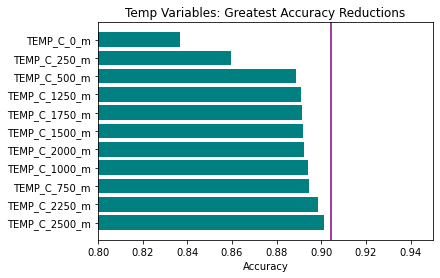

In [12]:
plt.xlim(0.80, 0.95)
plt.barh(singlepass_results[["TEMP_C" in var for var in singlepass_results.index]].index[10::-1], 
         temp_imp[:, 1][10::-1], color=color_values[0])
plt.axvline(x=0.9042, color="purple")
plt.title("Temp Variables: Greatest Accuracy Reductions")
plt.xlabel("Accuracy")
plt.savefig("perm_imp_full_single_temp.png", dpi=300, bbox_inches="tight")

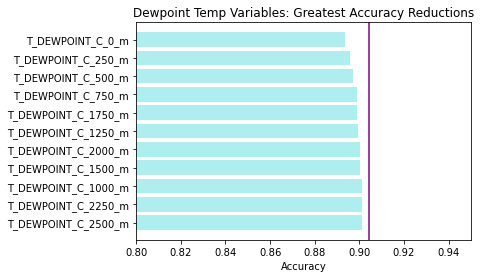

In [13]:
plt.xlim(0.80, 0.95)
plt.barh(singlepass_results[["T_D" in var for var in singlepass_results.index]].index[10::-1], 
         dewtemp_imp[:, 1][10::-1], color=color_values[1])
plt.title("Dewpoint Temp Variables: Greatest Accuracy Reductions")
plt.axvline(x=0.9042, color="purple")
plt.xlabel("Accuracy")
plt.savefig("perm_imp_dewtemp_single.png", dpi=300, bbox_inches="tight")

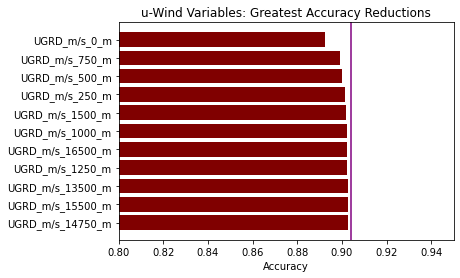

In [14]:
plt.xlim(0.80, 0.95)
plt.barh(singlepass_results[["UGRD" in var for var in singlepass_results.index]].index[10::-1], 
         ugrd_imp[:, 1][10::-1], color=color_values[2])
plt.title("u-Wind Variables: Greatest Accuracy Reductions")
plt.axvline(x=0.9042, color="purple")
plt.xlabel("Accuracy")
plt.savefig("perm_imp_ugrd_single.png", dpi=300, bbox_inches="tight")

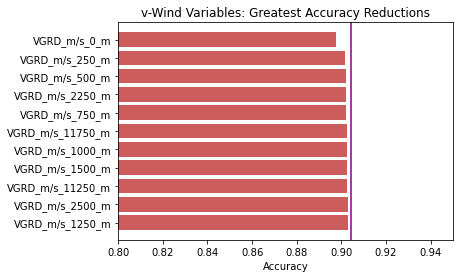

In [15]:
plt.xlim(0.80, 0.95)
plt.barh(singlepass_results[["VGRD" in var for var in singlepass_results.index]].index[10::-1], 
         vgrd_imp[:, 1][10::-1], color=color_values[3])
plt.title("v-Wind Variables: Greatest Accuracy Reductions")
plt.axvline(x=0.9042, color="purple")
plt.xlabel("Accuracy")
plt.savefig("perm_imp_vgrd_single.png", dpi=300, bbox_inches="tight")

## Backwards Singlepass Permutation: Ice Pellets

### Original Accuracy: Ice Pellets

In [17]:
x_train = np.load("/glade/work/eliotk/modeling/mping_x_train.npy")
y_train = np.load("/glade/work/eliotk/modeling/mping_y_train.npy")
x_test = np.load("/glade/work/eliotk/modeling/mping_x_test.npy")
y_test = np.load("/glade/work/eliotk/modeling/mping_y_test.npy")
model = tf.keras.models.load_model('/glade/work/eliotk/modeling/mping_initial_mlp')

In [126]:
y_pred_train_onehot = model.predict(x_train)

In [127]:
# Converting one-hot labels to categorical labels
y_pred_labels = np.argmax(y_pred_onehot, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

In [128]:
y_pred_train_labels = np.argmax(y_pred_train_onehot, axis=1)
y_train_labels = np.argmax(y_train, axis=1)

In [129]:
pl_y_pred_labels = y_pred_labels[y_test_labels == 2]
pl_y_test_labels = y_test_labels[y_test_labels == 2]

In [130]:
pl_y_pred_train_labels = y_pred_train_labels[y_train_labels == 2]
pl_y_train_labels = y_train_labels[y_train_labels == 2]

In [131]:
accuracy_score(pl_y_test_labels, pl_y_pred_labels)

0.2330508474576271

In [132]:
accuracy_score(pl_y_train_labels, pl_y_pred_train_labels)

0.4000517866390471

### Permutation

In [133]:
scoring_data = (x_train[y_train_labels == 2], y_train[y_train_labels == 2])

In [134]:
result = permutation_importance(scoring_data, score_model, 'min', variable_names=input_cols, nimportant_vars=1)

iter 897, prop pl 0.40833764888658725, acc 0.4000517866390471
iter 898, prop pl 0.41895390989124803, acc 0.4018643190056965
iter 899, prop pl 0.42128430864836874, acc 0.4013464526152253
iter 900, prop pl 0.4176592439150699, acc 0.40238218539616777
iter 901, prop pl 0.416882444329363, acc 0.40548938373899535
iter 902, prop pl 0.41455204557224234, acc 0.4093733816675298
iter 903, prop pl 0.41506991196271364, acc 0.4062661833247022
iter 904, prop pl 0.4137752459865355, acc 0.4031589849818747
iter 905, prop pl 0.41351631279129986, acc 0.4013464526152253
iter 906, prop pl 0.4158467115484205, acc 0.39668565510098397
iter 907, prop pl 0.4166235111341274, acc 0.3972035214914552
iter 908, prop pl 0.41351631279129986, acc 0.3990160538581046
iter 909, prop pl 0.4129984464008286, acc 0.40367685137234594
iter 910, prop pl 0.4142931123770067, acc 0.40031071983428274
iter 911, prop pl 0.41791817711030554, acc 0.39668565510098397
iter 912, prop pl 0.41455204557224234, acc 0.3951320559295702
iter 913, 

In [135]:
singlepass = result.retrieve_singlepass()

In [136]:
singlepass

{'UGRD_m/s_0_m': (0, 0.3689798032107716),
 'UGRD_m/s_500_m': (1, 0.3759709994821336),
 'VGRD_m/s_1000_m': (2, 0.37907819782496116),
 'VGRD_m/s_1250_m': (3, 0.3795960642154324),
 'T_DEWPOINT_C_3500_m': (4, 0.379854997410668),
 'VGRD_m/s_1750_m': (5, 0.38063179699637495),
 'VGRD_m/s_2000_m': (6, 0.38063179699637495),
 'T_DEWPOINT_C_3250_m': (7, 0.3814085965820818),
 'T_DEWPOINT_C_5500_m': (8, 0.3829621957534956),
 'UGRD_m/s_250_m': (9, 0.3839979285344381),
 'T_DEWPOINT_C_13500_m': (10, 0.38425686172967377),
 'T_DEWPOINT_C_14250_m': (11, 0.38529259451061626),
 'T_DEWPOINT_C_5250_m': (12, 0.3858104609010875),
 'UGRD_m/s_2750_m': (13, 0.3863283272915588),
 'UGRD_m/s_3500_m': (14, 0.3865872604867944),
 'T_DEWPOINT_C_6000_m': (15, 0.38710512687726567),
 'VGRD_m/s_11500_m': (16, 0.38710512687726567),
 'T_DEWPOINT_C_3750_m': (17, 0.38814085965820816),
 'T_DEWPOINT_C_14000_m': (18, 0.38814085965820816),
 'VGRD_m/s_15750_m': (19, 0.38814085965820816),
 'VGRD_m/s_15500_m': (20, 0.38839979285344384

In [21]:
# temp = pd.DataFrame(singlepass).transpose()
# temp.columns = ["Rank", "Accuracy"]
# temp.to_csv("perm_imp_pl_single_predcond.csv")

### Evaluation

In [18]:
singlepass_results = pd.read_csv("perm_imp_pl_single_corrected.csv", index_col=0)

In [19]:
singlepass_results.head(10)

,Rank,Accuracy
T_DEWPOINT_C_2500_m,0.0,0.519275
UGRD_m/s_500_m,1.0,0.520790
T_DEWPOINT_C_2750_m,2.0,0.521354
UGRD_m/s_0_m,3.0,0.521859
VGRD_m/s_0_m,4.0,0.525245
T_DEWPOINT_C_3250_m,5.0,0.526017
T_DEWPOINT_C_3000_m,6.0,0.526879
UGRD_m/s_750_m,7.0,0.528987
UGRD_m/s_2500_m,8.0,0.529165
UGRD_m/s_250_m,9.0,0.529552


In [20]:
colors = {"TEM":"teal", "T_D":"paleturquoise", "UGR":"maroon", "VGR":"indianred"}

In [21]:
color_values = ["teal", "paleturquoise", "maroon", "indianred"]

In [22]:
bar_colors = [colors[i] for i in [var[:3] for var in singlepass_results.index]]

In [23]:
m = 10
temp_hand = mlines.Line2D([], [], color=color_values[0], marker='o', linestyle="None", label="Temp", markersize=m)
dewtemp_hand = mlines.Line2D([], [], color=color_values[1], marker='o', linestyle="None", label="Dewpoint Temp", markersize=m)
ugrd_hand = mlines.Line2D([], [], color=color_values[2], marker='o', linestyle="None", label="u-Wind", markersize=m)
vgrd_hand = mlines.Line2D([], [], color=color_values[3], marker='o', linestyle="None", label="v-Wind", markersize=m)

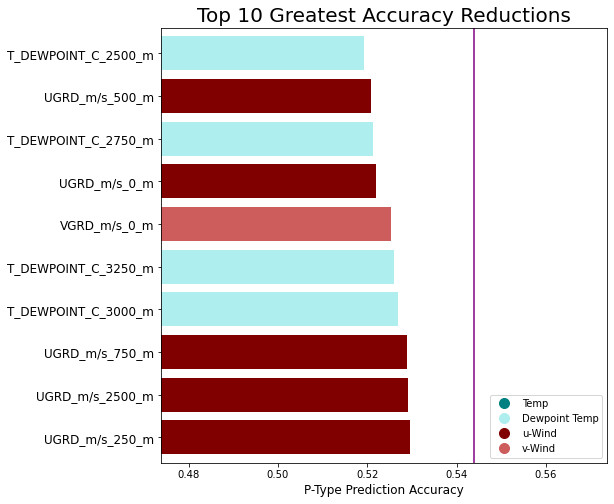

In [31]:
plt.figure(figsize=(8, 8))
plt.barh(singlepass_results.index[9::-1], singlepass_results.iloc[:, 1][9::-1], color=bar_colors[9::-1])
plt.yticks(fontsize=12)
plt.xlim(0.4738, 0.5738)
plt.margins(y=0.02)
plt.axvline(x=0.5438, color="purple")
plt.xlabel("P-Type Prediction Accuracy", fontsize=12)
plt.title("Top 10 Greatest Accuracy Reductions", fontsize=20)
plt.legend(handles=[temp_hand, dewtemp_hand, ugrd_hand, vgrd_hand], loc="lower right")
plt.savefig("perm_imp_pl_single.png", dpi=300, bbox_inches="tight")

In [25]:
temp_imp = np.array([singlepass_results.loc[var] for var in singlepass_results.index if "TEMP_C" in var])
dewtemp_imp = np.array([singlepass_results.loc[var] for var in singlepass_results.index if "T_DEW" in var])
ugrd_imp = np.array([singlepass_results.loc[var] for var in singlepass_results.index if "UGRD" in var])
vgrd_imp = np.array([singlepass_results.loc[var] for var in singlepass_results.index if "VGRD" in var])

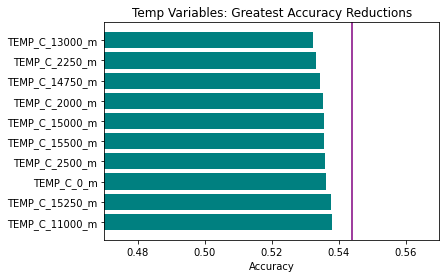

In [27]:
# plt.figure(figsize=(10, 30))
plt.xlim(0.47, 0.57)
plt.barh(singlepass_results[["TEMP_C" in var for var in singlepass_results.index]].index[9::-1], 
         temp_imp[:, 1][9::-1], color=color_values[0])
plt.axvline(x=0.5438, color="purple")
plt.title("Temp Variables: Greatest Accuracy Reductions")
plt.xlabel("Accuracy")
plt.savefig("perm_imp_pl_temp_single.png", dpi=300, bbox_inches="tight")

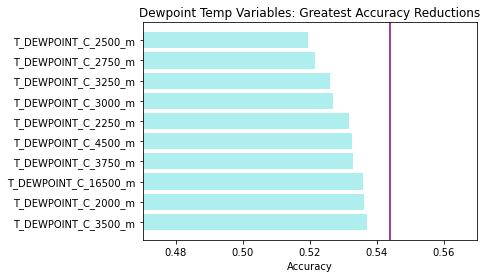

In [28]:
plt.xlim(0.47, 0.57)
plt.barh(singlepass_results[["T_D" in var for var in singlepass_results.index]].index[9::-1], 
         dewtemp_imp[:, 1][9::-1], color=color_values[1])
plt.title("Dewpoint Temp Variables: Greatest Accuracy Reductions")
plt.axvline(x=0.5438, color="purple")
plt.xlabel("Accuracy")
plt.savefig("perm_imp_pl_dewtemp_single.png", dpi=300, bbox_inches="tight")

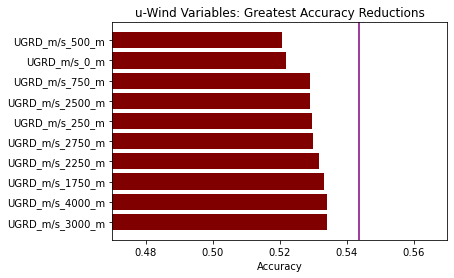

In [29]:
plt.xlim(0.47, 0.57)
plt.barh(singlepass_results[["UGRD" in var for var in singlepass_results.index]].index[9::-1], 
         ugrd_imp[:, 1][9::-1], color=color_values[2])
plt.title("u-Wind Variables: Greatest Accuracy Reductions")
plt.axvline(x=0.5438, color="purple")
plt.xlabel("Accuracy")
plt.savefig("perm_imp_pl_ugrd_single.png", dpi=300, bbox_inches="tight")

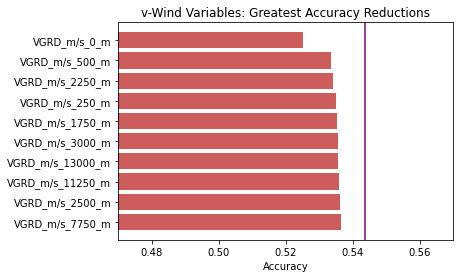

In [30]:
plt.xlim(0.47, 0.57)
plt.barh(singlepass_results[["VGRD" in var for var in singlepass_results.index]].index[9::-1], 
         vgrd_imp[:, 1][9::-1], color=color_values[3])
plt.title("v-Wind Variables: Greatest Accuracy Reductions")
plt.axvline(x=0.5438, color="purple")
plt.xlabel("Accuracy")
plt.savefig("perm_imp_pl_vgrd_single.png", dpi=300, bbox_inches="tight")

## Backwards Singlepass Permutation: Freezing Rain

### Original Accuracy: Freezing Rain

In [34]:
y_pred_onehot = model.predict(x_test)

In [35]:
y_pred_train_onehot = model.predict(x_train)

In [36]:
# Converting one-hot labels to categorical labels
y_pred_labels = np.argmax(y_pred_onehot, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

In [37]:
y_pred_train_labels = np.argmax(y_pred_train_onehot, axis=1)
y_train_labels = np.argmax(y_train, axis=1)

In [38]:
pl_y_pred_labels = y_pred_labels[y_pred_labels == 3]
pl_y_test_labels = y_test_labels[y_pred_labels == 3]

In [39]:
pl_y_pred_train_labels = y_pred_train_labels[y_pred_train_labels == 3]
pl_y_train_labels = y_train_labels[y_pred_train_labels == 3]

In [40]:
accuracy_score(pl_y_test_labels, pl_y_pred_labels)

0.4343220338983051

In [41]:
accuracy_score(pl_y_train_labels, pl_y_pred_train_labels)

0.6315159429752966

### Permutation

In [42]:
scoring_data = (x_train[y_pred_train_labels == 3], y_train[y_pred_train_labels == 3])

In [45]:
result = permutation_importance(scoring_data, score_model, 'min', variable_names=input_cols, nimportant_vars=1)

iter 0, prop pl 1.0, acc 0.6315159429752966
iter 1, prop pl 0.9352486668843182, acc 0.6228098813799108
iter 2, prop pl 0.9564696920230711, acc 0.6277070410273152
iter 3, prop pl 0.9721406028947654, acc 0.6308629883556426
iter 4, prop pl 0.9727935575144194, acc 0.6302100337359887
iter 5, prop pl 0.9673522690173033, acc 0.6289041244966808
iter 6, prop pl 0.9661551855479378, acc 0.6292306018065078
iter 7, prop pl 0.9640874959190336, acc 0.6305365110458157
iter 8, prop pl 0.9591903362716291, acc 0.630645336815758
iter 9, prop pl 0.9595168135814561, acc 0.6297747306562194
iter 10, prop pl 0.9694199586462074, acc 0.6305365110458157
iter 11, prop pl 0.9752965502230928, acc 0.630318859505931
iter 12, prop pl 0.9645227989988029, acc 0.6277070410273152
iter 13, prop pl 0.9620198062901295, acc 0.6281423441070846
iter 14, prop pl 0.9502666231363587, acc 0.6280335183371423
iter 15, prop pl 0.9587550331918598, acc 0.6289041244966808
iter 16, prop pl 0.9783436717814779, acc 0.6314071172053543
iter 17

In [46]:
singlepass = result.retrieve_singlepass()

In [47]:
temp = pd.DataFrame(singlepass).transpose()
temp.columns = ["Rank", "Accuracy"]
temp.to_csv("perm_imp_fzra_single_predcond.csv")

### Evaluation

In [41]:
singlepass_results = pd.read_csv("perm_imp_fzra_single_corrected.csv", index_col=0)

In [42]:
colors = {"TEM":"teal", "T_D":"paleturquoise", "UGR":"maroon", "VGR":"indianred"}

In [43]:
color_values = ["teal", "paleturquoise", "maroon", "indianred"]

In [44]:
bar_colors = [colors[i] for i in [var[:3] for var in singlepass_results.index]]

In [45]:
m = 10
temp_hand = mlines.Line2D([], [], color=color_values[0], marker='o', linestyle="None", label="Temp", markersize=m)
dewtemp_hand = mlines.Line2D([], [], color=color_values[1], marker='o', linestyle="None", label="Dewpoint Temp", markersize=m)
ugrd_hand = mlines.Line2D([], [], color=color_values[2], marker='o', linestyle="None", label="u-Wind", markersize=m)
vgrd_hand = mlines.Line2D([], [], color=color_values[3], marker='o', linestyle="None", label="v-Wind", markersize=m)

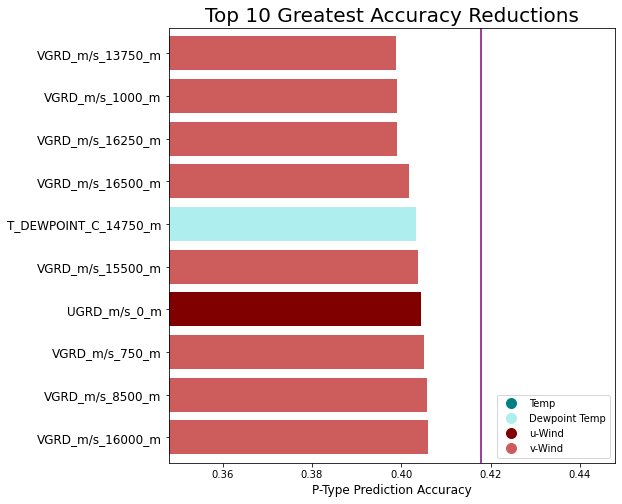

In [46]:
plt.figure(figsize=(8, 8))
plt.barh(singlepass_results.index[9::-1], singlepass_results.iloc[:, 1][9::-1], color=bar_colors[9::-1])
plt.yticks(fontsize=12)
plt.xlim(0.3479, 0.4479)
plt.margins(y=0.02)
plt.axvline(x=0.4179, color="purple")
plt.xlabel("P-Type Prediction Accuracy", fontsize=12)
plt.title("Top 10 Greatest Accuracy Reductions", fontsize=20)
plt.legend(handles=[temp_hand, dewtemp_hand, ugrd_hand, vgrd_hand], loc="lower right")
plt.savefig("perm_imp_fzra_single.png", dpi=300, bbox_inches="tight")

In [47]:
temp_imp = np.array([singlepass_results.loc[var] for var in singlepass_results.index if "TEMP_C" in var])
dewtemp_imp = np.array([singlepass_results.loc[var] for var in singlepass_results.index if "T_DEW" in var])
ugrd_imp = np.array([singlepass_results.loc[var] for var in singlepass_results.index if "UGRD" in var])
vgrd_imp = np.array([singlepass_results.loc[var] for var in singlepass_results.index if "VGRD" in var])

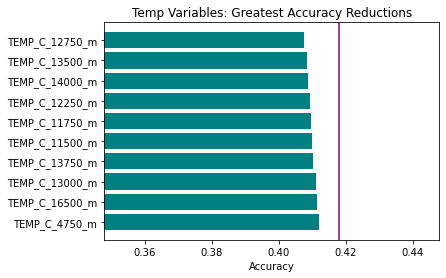

In [50]:
# plt.figure(figsize=(10, 30))
plt.xlim(0.3479, 0.4479)
plt.barh(singlepass_results[["TEMP_C" in var for var in singlepass_results.index]].index[9::-1], 
         temp_imp[:, 1][9::-1], color=color_values[0])
plt.axvline(x=0.4179, color="purple")
plt.title("Temp Variables: Greatest Accuracy Reductions")
plt.xlabel("Accuracy")
plt.savefig("perm_imp_fzra_temp_single.png", dpi=300, bbox_inches="tight")

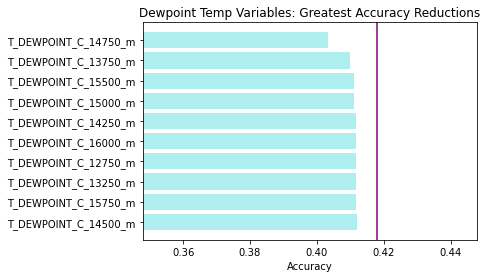

In [51]:
plt.xlim(0.3479, 0.4479)
plt.barh(singlepass_results[["T_D" in var for var in singlepass_results.index]].index[9::-1], 
         dewtemp_imp[:, 1][9::-1], color=color_values[1])
plt.title("Dewpoint Temp Variables: Greatest Accuracy Reductions")
plt.axvline(x=0.4179, color="purple")
plt.xlabel("Accuracy")
plt.savefig("perm_imp_fzra_dewtemp_single.png", dpi=300, bbox_inches="tight")

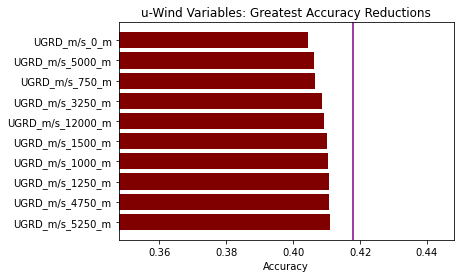

In [52]:
plt.xlim(0.3479, 0.4479)
plt.barh(singlepass_results[["UGRD" in var for var in singlepass_results.index]].index[9::-1], 
         ugrd_imp[:, 1][9::-1], color=color_values[2])
plt.title("u-Wind Variables: Greatest Accuracy Reductions")
plt.axvline(x=0.4179, color="purple")
plt.xlabel("Accuracy")
plt.savefig("perm_imp_fzra_ugrd_single.png", dpi=300, bbox_inches="tight")

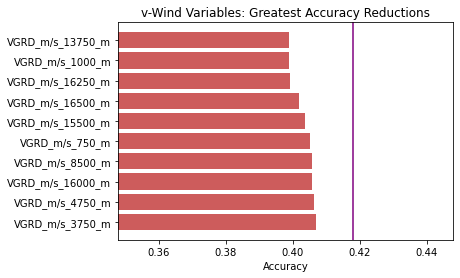

In [53]:
plt.xlim(0.3479, 0.4479)
plt.barh(singlepass_results[["VGRD" in var for var in singlepass_results.index]].index[9::-1], 
         vgrd_imp[:, 1][9::-1], color=color_values[3])
plt.title("v-Wind Variables: Greatest Accuracy Reductions")
plt.axvline(x=0.4179, color="purple")
plt.xlabel("Accuracy")
plt.savefig("perm_imp_fzra_vgrd_single.png", dpi=300, bbox_inches="tight")

## Backwards Singlepass Permutation: Rain

### Original Accuracy: Rain

In [63]:
y_pred_onehot = model.predict(x_test)

In [64]:
y_pred_train_onehot = model.predict(x_train)

In [65]:
# Converting one-hot labels to categorical labels
y_pred_labels = np.argmax(y_pred_onehot, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

In [66]:
y_pred_train_labels = np.argmax(y_pred_train_onehot, axis=1)
y_train_labels = np.argmax(y_train, axis=1)

In [67]:
pl_y_pred_labels = y_pred_labels[y_pred_labels == 0]
pl_y_test_labels = y_test_labels[y_pred_labels == 0]

In [68]:
pl_y_pred_train_labels = y_pred_train_labels[y_pred_train_labels == 0]
pl_y_train_labels = y_train_labels[y_pred_train_labels == 0]

In [69]:
accuracy_score(pl_y_test_labels, pl_y_pred_labels)

0.950060045107056

In [70]:
accuracy_score(pl_y_train_labels, pl_y_pred_train_labels)

0.9619717800289436

### Permutation

In [71]:
scoring_data = (x_train[y_pred_train_labels == 0], y_train[y_pred_train_labels == 0])

In [74]:
result = permutation_importance(scoring_data, score_model, 'min', variable_names=input_cols, nimportant_vars=1)

iter 0, prop pl 1.0, acc 0.9619717800289436
iter 1, prop pl 0.996931982633864, acc 0.961226483357453
iter 2, prop pl 0.9981295224312591, acc 0.9617040520984081
iter 3, prop pl 0.9988531114327063, acc 0.9620984081041968
iter 4, prop pl 0.9991461649782923, acc 0.9619826338639653
iter 5, prop pl 0.9991895803183791, acc 0.9619862518089725
iter 6, prop pl 0.9980499276410999, acc 0.9618198263386396
iter 7, prop pl 0.9956946454413893, acc 0.961089001447178
iter 8, prop pl 0.9945513748191027, acc 0.9606657018813314
iter 9, prop pl 0.996226483357453, acc 0.9612373371924747
iter 10, prop pl 0.9919356005788712, acc 0.9604377713458755
iter 11, prop pl 0.9967366136034732, acc 0.9615882778581766
iter 12, prop pl 0.9933646888567293, acc 0.9613458755426918
iter 13, prop pl 0.9934551374819103, acc 0.9613169319826339
iter 14, prop pl 0.9901881331403762, acc 0.9607199710564399
iter 15, prop pl 0.9955969609261939, acc 0.9613458755426918
iter 16, prop pl 0.9979992764109985, acc 0.9618306801736614
iter 17, 

In [75]:
singlepass = result.retrieve_singlepass()

In [76]:
temp = pd.DataFrame(singlepass).transpose()
temp.columns = ["Rank", "Accuracy"]
temp.to_csv("perm_imp_ra_single_predcond.csv")

### Evaluation

In [54]:
singlepass_results = pd.read_csv("perm_imp_ra_single_corrected.csv", index_col=0)

In [55]:
colors = {"TEM":"teal", "T_D":"paleturquoise", "UGR":"maroon", "VGR":"indianred"}

In [56]:
color_values = ["teal", "paleturquoise", "maroon", "indianred"]

In [57]:
bar_colors = [colors[i] for i in [var[:3] for var in singlepass_results.index]]

In [58]:
m = 10
temp_hand = mlines.Line2D([], [], color=color_values[0], marker='o', linestyle="None", label="Temp", markersize=m)
dewtemp_hand = mlines.Line2D([], [], color=color_values[1], marker='o', linestyle="None", label="Dewpoint Temp", markersize=m)
ugrd_hand = mlines.Line2D([], [], color=color_values[2], marker='o', linestyle="None", label="u-Wind", markersize=m)
vgrd_hand = mlines.Line2D([], [], color=color_values[3], marker='o', linestyle="None", label="v-Wind", markersize=m)

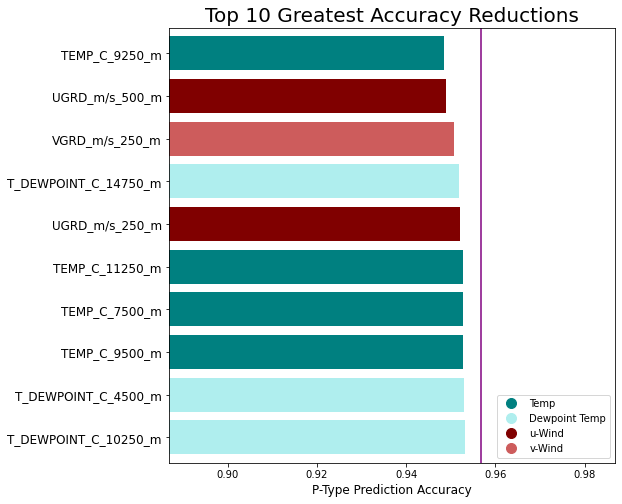

In [59]:
plt.figure(figsize=(8, 8))
plt.barh(singlepass_results.index[9::-1], singlepass_results.iloc[:, 1][9::-1], color=bar_colors[9::-1])
plt.yticks(fontsize=12)
plt.xlim(0.8868, 0.9868)
plt.margins(y=0.02)
plt.axvline(x=0.9568, color="purple")
plt.xlabel("P-Type Prediction Accuracy", fontsize=12)
plt.title("Top 10 Greatest Accuracy Reductions", fontsize=20)
plt.legend(handles=[temp_hand, dewtemp_hand, ugrd_hand, vgrd_hand], loc="lower right")
plt.savefig("perm_imp_ra_single.png", dpi=300, bbox_inches="tight")

In [60]:
temp_imp = np.array([singlepass_results.loc[var] for var in singlepass_results.index if "TEMP_C" in var])
dewtemp_imp = np.array([singlepass_results.loc[var] for var in singlepass_results.index if "T_DEW" in var])
ugrd_imp = np.array([singlepass_results.loc[var] for var in singlepass_results.index if "UGRD" in var])
vgrd_imp = np.array([singlepass_results.loc[var] for var in singlepass_results.index if "VGRD" in var])

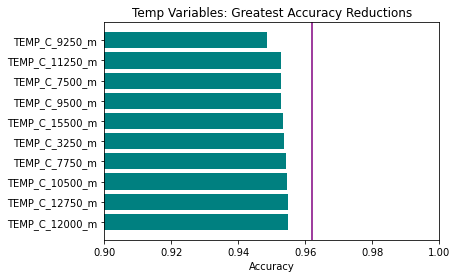

In [61]:
# plt.figure(figsize=(10, 30))
plt.xlim(0.90, 1)
plt.barh(singlepass_results[["TEMP_C" in var for var in singlepass_results.index]].index[9::-1], 
         temp_imp[:, 1][9::-1], color=color_values[0])
plt.axvline(x=0.9620, color="purple")
plt.title("Temp Variables: Greatest Accuracy Reductions")
plt.xlabel("Accuracy")
plt.savefig("perm_imp_ra_temp_single.png", dpi=300, bbox_inches="tight")

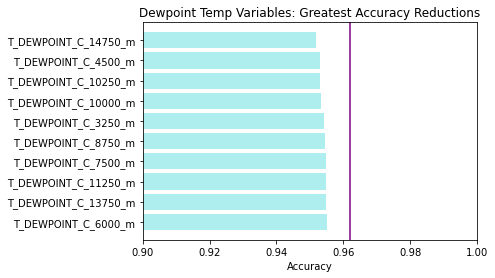

In [62]:
plt.xlim(0.90, 1)
plt.barh(singlepass_results[["T_D" in var for var in singlepass_results.index]].index[9::-1], 
         dewtemp_imp[:, 1][9::-1], color=color_values[1])
plt.title("Dewpoint Temp Variables: Greatest Accuracy Reductions")
plt.axvline(x=0.9620, color="purple")
plt.xlabel("Accuracy")
plt.savefig("perm_imp_ra_dewtemp_single.png", dpi=300, bbox_inches="tight")

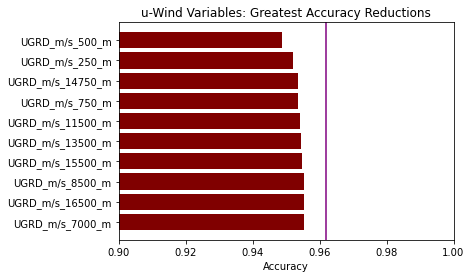

In [63]:
plt.xlim(0.90, 1)
plt.barh(singlepass_results[["UGRD" in var for var in singlepass_results.index]].index[9::-1], 
         ugrd_imp[:, 1][9::-1], color=color_values[2])
plt.title("u-Wind Variables: Greatest Accuracy Reductions")
plt.axvline(x=0.9620, color="purple")
plt.xlabel("Accuracy")
plt.savefig("perm_imp_ra_ugrd_single.png", dpi=300, bbox_inches="tight")

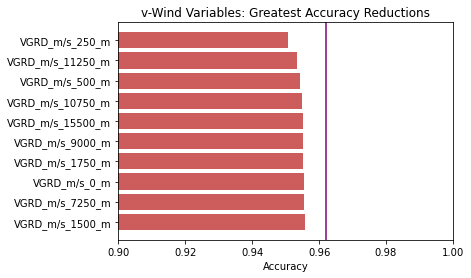

In [64]:
plt.xlim(0.90, 1)
plt.barh(singlepass_results[["VGRD" in var for var in singlepass_results.index]].index[9::-1], 
         vgrd_imp[:, 1][9::-1], color=color_values[3])
plt.title("v-Wind Variables: Greatest Accuracy Reductions")
plt.axvline(x=0.9620, color="purple")
plt.xlabel("Accuracy")
plt.savefig("perm_imp_ra_vgrd_single.png", dpi=300, bbox_inches="tight")

## Backwards Singlepass Permutation: Snow

### Original Accuracy: Snow

In [89]:
y_pred_onehot = model.predict(x_test)

In [90]:
y_pred_train_onehot = model.predict(x_train)

In [91]:
# Converting one-hot labels to categorical labels
y_pred_labels = np.argmax(y_pred_onehot, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

In [92]:
y_pred_train_labels = np.argmax(y_pred_train_onehot, axis=1)
y_train_labels = np.argmax(y_train, axis=1)

In [93]:
pl_y_pred_labels = y_pred_labels[y_pred_labels == 1]
pl_y_test_labels = y_test_labels[y_pred_labels == 1]

In [94]:
pl_y_pred_train_labels = y_pred_train_labels[y_pred_train_labels == 1]
pl_y_train_labels = y_train_labels[y_pred_train_labels == 1]

In [95]:
accuracy_score(pl_y_test_labels, pl_y_pred_labels)

0.8497861420017109

In [96]:
accuracy_score(pl_y_train_labels, pl_y_pred_train_labels)

0.8780115624147086

### Permutation

In [97]:
scoring_data = (x_train[y_pred_train_labels == 1], y_train[y_pred_train_labels == 1])

In [99]:
result = permutation_importance(scoring_data, score_model, 'min', variable_names=input_cols, nimportant_vars=1)

iter 0, prop pl 1.0, acc 0.8780115624147086
iter 1, prop pl 0.9828982954122522, acc 0.8724598665111778
iter 2, prop pl 0.9886795027665435, acc 0.874879041262437
iter 3, prop pl 0.9916259335533335, acc 0.8757412599558345
iter 4, prop pl 0.9931332655137335, acc 0.876801975039079
iter 5, prop pl 0.9951120264000198, acc 0.8771989678187728
iter 6, prop pl 0.9931952956355606, acc 0.876646899734511
iter 7, prop pl 0.9911545046274471, acc 0.8759211473091333
iter 8, prop pl 0.9909373992010521, acc 0.875666823809642
iter 9, prop pl 0.993952063121852, acc 0.8765848696126839
iter 10, prop pl 0.993077438404089, acc 0.8762623129791827
iter 11, prop pl 0.9956516884599161, acc 0.8772299828796863
iter 12, prop pl 0.9942374016822569, acc 0.8767709599781653
iter 13, prop pl 0.9946468004863162, acc 0.877149343721311
iter 14, prop pl 0.9936419125127162, acc 0.8767523509416173
iter 15, prop pl 0.9954221770091557, acc 0.8773168250502444
iter 16, prop pl 0.9952360866436741, acc 0.8772113738431382
iter 17, pro

In [100]:
singlepass = result.retrieve_singlepass()

In [101]:
singlepass

{'UGRD_m/s_0_m': (0, 0.8542726347914548),
 'T_DEWPOINT_C_0_m': (1, 0.8630871151030941),
 'VGRD_m/s_0_m': (2, 0.865928094682778),
 'T_DEWPOINT_C_250_m': (3, 0.8662258392675484),
 'T_DEWPOINT_C_500_m': (4, 0.8692715182492619),
 'T_DEWPOINT_C_4500_m': (5, 0.8715046026350396),
 'UGRD_m/s_750_m': (6, 0.872391633377168),
 'TEMP_C_0_m': (7, 0.8724598665111778),
 'T_DEWPOINT_C_5250_m': (8, 0.8727203930228519),
 'UGRD_m/s_1500_m': (9, 0.8735019725578741),
 'T_DEWPOINT_C_4000_m': (10, 0.8737376870208173),
 'UGRD_m/s_16500_m': (11, 0.8740354316055877),
 'VGRD_m/s_11750_m': (12, 0.874357988239089),
 'T_DEWPOINT_C_3500_m': (13, 0.8744200183609161),
 'VGRD_m/s_250_m': (14, 0.8745378755923877),
 'VGRD_m/s_8750_m': (15, 0.8747984021040617),
 'UGRD_m/s_13250_m': (16, 0.8748480262015235),
 'TEMP_C_250_m': (17, 0.874879041262437),
 'T_DEWPOINT_C_3250_m': (18, 0.874879041262437),
 'UGRD_m/s_2250_m': (19, 0.8749348683720815),
 'UGRD_m/s_1250_m': (20, 0.8751953948837555),
 'UGRD_m/s_500_m': (21, 0.875226409

In [102]:
temp = pd.DataFrame(singlepass).transpose()
temp.columns = ["Rank", "Accuracy"]
temp.to_csv("perm_imp_sn_single_predcond.csv")

### Evaluation

In [65]:
singlepass_results = pd.read_csv("perm_imp_sn_single_corrected.csv", index_col=0)

In [66]:
colors = {"TEM":"teal", "T_D":"paleturquoise", "UGR":"maroon", "VGR":"indianred"}

In [67]:
color_values = ["teal", "paleturquoise", "maroon", "indianred"]

In [68]:
bar_colors = [colors[i] for i in [var[:3] for var in singlepass_results.index]]

In [69]:
m = 10
temp_hand = mlines.Line2D([], [], color=color_values[0], marker='o', linestyle="None", label="Temp", markersize=m)
dewtemp_hand = mlines.Line2D([], [], color=color_values[1], marker='o', linestyle="None", label="Dewpoint Temp", markersize=m)
ugrd_hand = mlines.Line2D([], [], color=color_values[2], marker='o', linestyle="None", label="u-Wind", markersize=m)
vgrd_hand = mlines.Line2D([], [], color=color_values[3], marker='o', linestyle="None", label="v-Wind", markersize=m)

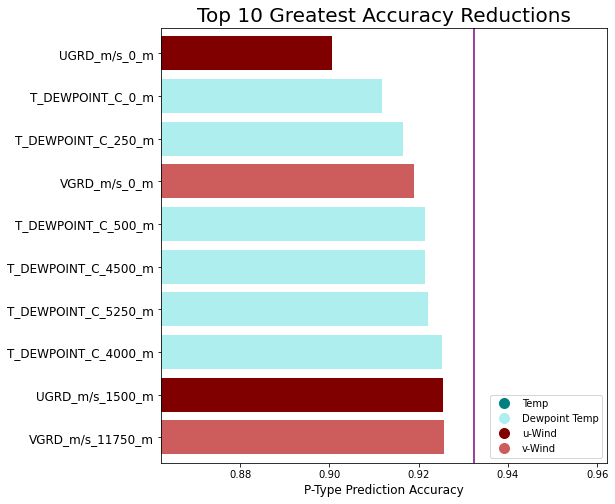

In [70]:
plt.figure(figsize=(8, 8))
plt.barh(singlepass_results.index[9::-1], singlepass_results.iloc[:, 1][9::-1], color=bar_colors[9::-1])
plt.yticks(fontsize=12)
plt.xlim(0.8623, 0.9623)
plt.margins(y=0.02)
plt.axvline(x=0.9323, color="purple")
plt.xlabel("P-Type Prediction Accuracy", fontsize=12)
plt.title("Top 10 Greatest Accuracy Reductions", fontsize=20)
plt.legend(handles=[temp_hand, dewtemp_hand, ugrd_hand, vgrd_hand], loc="lower right")
plt.savefig("perm_imp_sn_single.png", dpi=300, bbox_inches="tight")

In [71]:
temp_imp = np.array([singlepass_results.loc[var] for var in singlepass_results.index if "TEMP_C" in var])
dewtemp_imp = np.array([singlepass_results.loc[var] for var in singlepass_results.index if "T_DEW" in var])
ugrd_imp = np.array([singlepass_results.loc[var] for var in singlepass_results.index if "UGRD" in var])
vgrd_imp = np.array([singlepass_results.loc[var] for var in singlepass_results.index if "VGRD" in var])

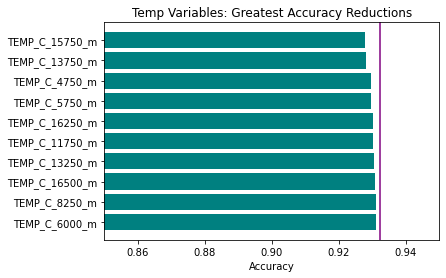

In [72]:
# plt.figure(figsize=(10, 30))
plt.xlim(0.85, 0.95)
plt.barh(singlepass_results[["TEMP_C" in var for var in singlepass_results.index]].index[9::-1], 
         temp_imp[:, 1][9::-1], color=color_values[0])
plt.axvline(x=0.9323, color="purple")
plt.title("Temp Variables: Greatest Accuracy Reductions")
plt.xlabel("Accuracy")
plt.savefig("perm_imp_sn_temp_single.png", dpi=300, bbox_inches="tight")

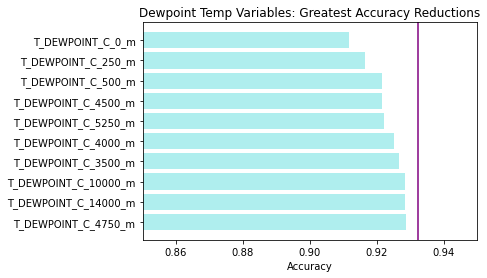

In [73]:
plt.xlim(0.85, 0.95)
plt.barh(singlepass_results[["T_D" in var for var in singlepass_results.index]].index[9::-1], 
         dewtemp_imp[:, 1][9::-1], color=color_values[1])
plt.title("Dewpoint Temp Variables: Greatest Accuracy Reductions")
plt.axvline(x=0.9323, color="purple")
plt.xlabel("Accuracy")
plt.savefig("perm_imp_sn_dewtemp_single.png", dpi=300, bbox_inches="tight")

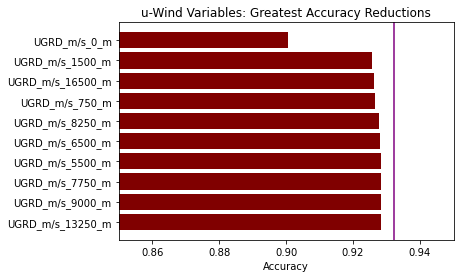

In [74]:
plt.xlim(0.85, 0.95)
plt.barh(singlepass_results[["UGRD" in var for var in singlepass_results.index]].index[9::-1], 
         ugrd_imp[:, 1][9::-1], color=color_values[2])
plt.title("u-Wind Variables: Greatest Accuracy Reductions")
plt.axvline(x=0.9323, color="purple")
plt.xlabel("Accuracy")
plt.savefig("perm_imp_sn_ugrd_single.png", dpi=300, bbox_inches="tight")

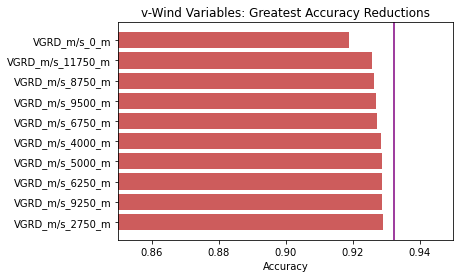

In [75]:
plt.xlim(0.85, 0.95)
plt.barh(singlepass_results[["VGRD" in var for var in singlepass_results.index]].index[9::-1], 
         vgrd_imp[:, 1][9::-1], color=color_values[3])
plt.title("v-Wind Variables: Greatest Accuracy Reductions")
plt.axvline(x=0.9323, color="purple")
plt.xlabel("Accuracy")
plt.savefig("perm_imp_sn_vgrd_single.png", dpi=300, bbox_inches="tight")

# **Model Re-Training with 10 Most Important Variables**

In [184]:
singlepass_results.head(10)

,Rank,Accuracy
TEMP_C_0_m,0.0,0.836530
TEMP_C_250_m,1.0,0.859585
TEMP_C_500_m,2.0,0.888844
TEMP_C_1250_m,3.0,0.890820
TEMP_C_1750_m,4.0,0.891306
TEMP_C_1500_m,5.0,0.891779
TEMP_C_2000_m,6.0,0.892253
UGRD_m/s_0_m,7.0,0.892557
T_DEWPOINT_C_0_m,8.0,0.893617
TEMP_C_1000_m,9.0,0.894214


In [185]:
x_train.shape, x_test.shape

((477257, 268), (63552, 268))

In [186]:
x_train_imp = x_train[:, [train_data[input_cols].columns.get_loc(i) for i in singlepass_results.index[9::-1]]]
x_test_imp = x_test[:, [train_data[input_cols].columns.get_loc(i) for i in singlepass_results.index[9::-1]]]
x_valid_imp = x_valid[:, [train_data[input_cols].columns.get_loc(i) for i in singlepass_results.index[9::-1]]]

In [187]:
x_train_imp.shape

(477257, 10)

In [188]:
x_test_imp.shape

(63552, 10)

In [189]:
x_valid_imp.shape

(67831, 10)

## Model Training

In [190]:
# Set batch size
batch_size = conf["batch_size"]

In [191]:
def build_model(input_size, hidden_size, output_size):
    model = tf.keras.models.Sequential(
        [tf.keras.layers.Dense(input_size, activation='relu'),
        tf.keras.layers.Dense(hidden_size, activation='relu'),
        tf.keras.layers.Dense(output_size, activation='softmax')]
    )
    return model

In [192]:
model = build_model(10, 100, len(output_cols))
model.build((batch_size, 10))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (4096, 10)                110       
                                                                 
 dense_10 (Dense)            (4096, 100)               1100      
                                                                 
 dense_11 (Dense)            (4096, 4)                 404       
                                                                 
Total params: 1,614
Trainable params: 1,614
Non-trainable params: 0
_________________________________________________________________


In [193]:
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(loss=loss, optimizer=optimizer, metrics='acc', run_eagerly=True) 

In [194]:
history = model.fit(x_train_imp, y_train, validation_data=(x_valid_imp, y_valid), batch_size=batch_size, shuffle=True, epochs=25) 

Epoch 1/25
117/117 [==============================] - 2s 14ms/step - loss: 0.6396 - acc: 0.7757 - val_loss: 0.4471 - val_acc: 0.8386
Epoch 2/25
117/117 [==============================] - 2s 14ms/step - loss: 0.4209 - acc: 0.8490 - val_loss: 0.4160 - val_acc: 0.8494
Epoch 3/25
117/117 [==============================] - 2s 14ms/step - loss: 0.3990 - acc: 0.8561 - val_loss: 0.4041 - val_acc: 0.8540
Epoch 4/25
117/117 [==============================] - 2s 14ms/step - loss: 0.3893 - acc: 0.8590 - val_loss: 0.4006 - val_acc: 0.8549
Epoch 5/25
117/117 [==============================] - 2s 13ms/step - loss: 0.3843 - acc: 0.8607 - val_loss: 0.3980 - val_acc: 0.8553
Epoch 6/25
117/117 [==============================] - 2s 14ms/step - loss: 0.3807 - acc: 0.8617 - val_loss: 0.3942 - val_acc: 0.8562
Epoch 7/25
117/117 [==============================] - 2s 13ms/step - loss: 0.3777 - acc: 0.8627 - val_loss: 0.3926 - val_acc: 0.8572
Epoch 8/25
117/117 [==============================] - 2s 13ms/step - 

## Model Evaluation

In [195]:
y_pred_onehot = model.predict(x_test_imp)

In [196]:
y_pred_train_onehot = model.predict(x_train_imp)

In [197]:
# Converting one-hot labels to categorical labels
y_pred_labels = np.argmax(y_pred_onehot, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

In [198]:
y_pred_train_labels = np.argmax(y_pred_train_onehot, axis=1)
y_train_labels = np.argmax(y_train, axis=1)

In [199]:
accuracy_score(y_train_labels, y_pred_train_labels)

0.8717651076883105

In [200]:
x_test_imp.shape, x_train_imp.shape

((63552, 10), (477257, 10))

In [201]:
accuracy_score(y_test_labels, y_pred_labels)

0.8563538519637462

Confusion matrix, without normalization
[[32401  1264   675   203]
 [ 1001 19698   936    50]
 [  788  2130  1881   322]
 [  414   572   774   443]]
Normalized confusion matrix
[[0.9379903308919318   0.0365920736473381   0.019540862113887038
  0.005876733346843065]
 [0.0461609407424487   0.9083698409038505   0.04316347705787411
  0.002305741295826608]
 [0.1538761960554579   0.4159343878148799   0.36731107205623903
  0.06287834407342316 ]
 [0.1879255560599183   0.259645937358148    0.3513390830685429
  0.20108942351339082 ]]


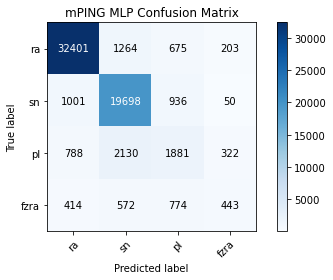

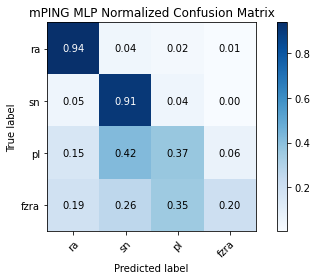

In [202]:
# _printoptions(precision=2)
# class_names = [str(x) for x in sorted(set(y_test_labels))]
class_names = ["ra", "sn", "pl", "fzra"]

# Plot non-normalized confusion matrix
utils.plot_confusion_matrix(y_test_labels, y_pred_labels, classes=class_names,
                      title='mPING MLP Confusion Matrix')

# Plot normalized confusion matrix
utils.plot_confusion_matrix(y_test_labels, y_pred_labels, classes=class_names, normalize=True,
                      title='mPING MLP Normalized Confusion Matrix')

plt.show()

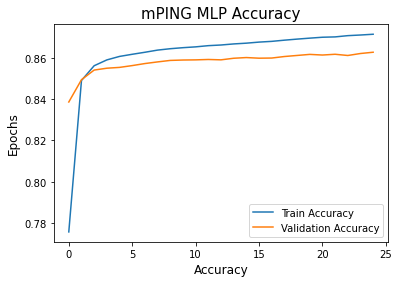

In [203]:
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.xlabel("Accuracy", fontsize=12)
plt.ylabel("Epochs", fontsize=12)
plt.title("mPING MLP Accuracy", fontsize=15) 
plt.legend(["Train Accuracy", "Validation Accuracy"])

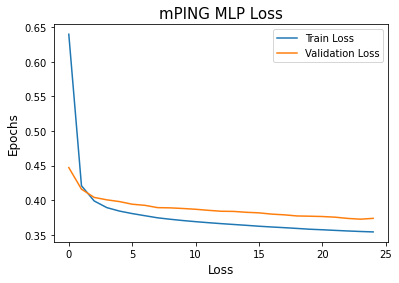

In [204]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Loss", fontsize=12)
plt.ylabel("Epochs", fontsize=12)
plt.title("mPING MLP Loss", fontsize=15) 
plt.legend(["Train Loss", "Validation Loss"])

In [210]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 10)                110       
                                                                 
 dense_10 (Dense)            (None, 100)               1100      
                                                                 
 dense_11 (Dense)            (None, 4)                 404       
                                                                 
Total params: 1,614
Trainable params: 1,614
Non-trainable params: 0
_________________________________________________________________


In [211]:
model.save("/glade/work/eliotk/modeling/mping_mlp_backsingleperm")

INFO:tensorflow:Assets written to: /glade/work/eliotk/modeling/mping_mlp_backsingleperm/assets


In [212]:
np.save("/glade/work/eliotk/modeling/mping_x_train_backsingleperm", x_train)

In [213]:
np.save("/glade/work/eliotk/modeling/mping_y_train_backsingleperm", y_train)

In [214]:
np.save("/glade/work/eliotk/modeling/mping_x_test_backsingleperm", x_test)

In [215]:
np.save("/glade/work/eliotk/modeling/mping_y_test_backsingleperm", y_test)